# Univariate to Univariate Prediction
**This notebook compares the current LSTM model trained on emotion data against two naive models**:

1. Mean Model: Takes the mean of all timesteps in the lookback period.
2. Learnable Weighted Mean Model: Computes a weighted mean of all previous timesteps, where the weights are learned.



### For prediction, I will explore two approaches:
1. Recursive Single Prediction: Predicts future time steps one at a time using previous prediction as input for the next prediction.
2. All-Timestep Prediction: Predicts all future timesteps in one shot.

Imports

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/Users/arnav/Google Drive/Cornell/Coding Projects/emili_TimeSeriesPredictor') #going up several files until emili_TimeSeriesPredictor
from time_series_predictor.Data.emotionFeatureExtractor import emotionFeatureExtractor
#Modeling imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Input, Lambda, Flatten
from tensorflow.keras.regularizers import l1, l2
import tensorflow.keras.backend as K
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

### **Generating Synthetic Data**

**Parameters**

In [29]:
delta_t = 0.1
synthetic_frequency = 10
lookback = 600
forecast = 1
stride = lookback + forecast #so no overlap

nSamples = 30
noise_lvl = 0.0

print(f'Number of seconds of data is {delta_t*(lookback+forecast)*nSamples}')

Number of seconds of data is 1803.0


**Univariate synthetic data:**

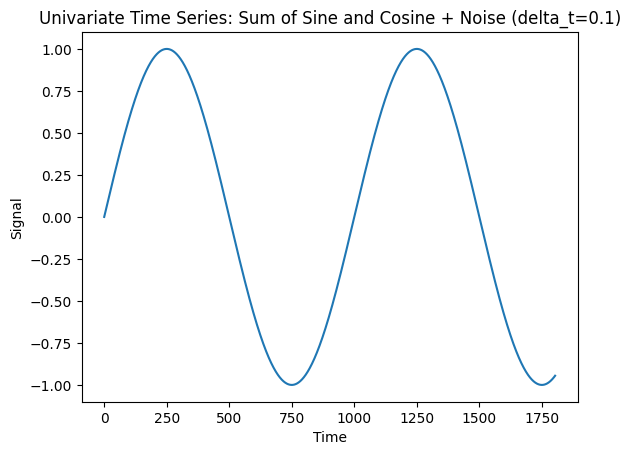

In [30]:

def gen_univariate_synthetic_data(timesteps, delta_t, frequency=0.001, noise_level=0.1):
    t = np.linspace(0, (timesteps-1)*delta_t, timesteps)

    # Generate sine wave based on frequency, where `frequency` is in Hz
    signal = np.sin(2 * np.pi * frequency * t)
    
    # Add noise to the signal
    noise = np.random.normal(0, noise_level, timesteps)

    return t, signal + noise

t,univariate_data = gen_univariate_synthetic_data(timesteps = (lookback+forecast)*nSamples, delta_t=delta_t, noise_level=noise_lvl)

plt.plot(t, univariate_data)
plt.title(f"Univariate Time Series: Sum of Sine and Cosine + Noise (delta_t={delta_t})")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.show()

**Creating train-test-split**

In [31]:

def train_test_split(data, lookback_period, forecast_period, stride, test_split = 0.2):
    # Ensure data is a numpy array
    data = np.array(data)

    # Initialize lists to hold the segmented data
    x, y = [], []

    # Loop over the dataset and create x and y using the sliding window approach
    for i in range(0, len(data) - lookback_period - forecast_period + 1, stride):
        x.append(data[i:i + lookback_period])
        y.append(data[i + lookback_period:i + lookback_period + forecast_period])

    # Convert lists to numpy arrays
    x = np.array(x)
    y = np.array(y)

    #creating new axis so data is (#samples, timesteps, features)
    if len(np.shape(x)) == 2:
        x = x[:,:,np.newaxis]
    if len(np.shape(y)) == 2:
        y = y[:,:,np.newaxis]

    # Determine the split point for the training and testing sets
    split_idx = int(np.shape(x)[0] * (1 - test_split))

    # Split the data into training and testing sets
    x_train, x_test = x[:split_idx], x[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    return x_train, y_train, x_test, y_test


xTr,yTr,xTe,yTe = train_test_split(data = univariate_data, lookback_period = lookback, forecast_period = forecast, stride = stride)
print(xTr.shape) # (samples, length of sample = lookback, features for timestep)
print(xTe.shape)
print(yTr.shape) # (samples, length of forecast = forecast, 1) Predicting 1 feature
print(yTe.shape)

(24, 600, 1)
(6, 600, 1)
(24, 1, 1)
(6, 1, 1)


**Plotting the univariate data train and test samples to verify**

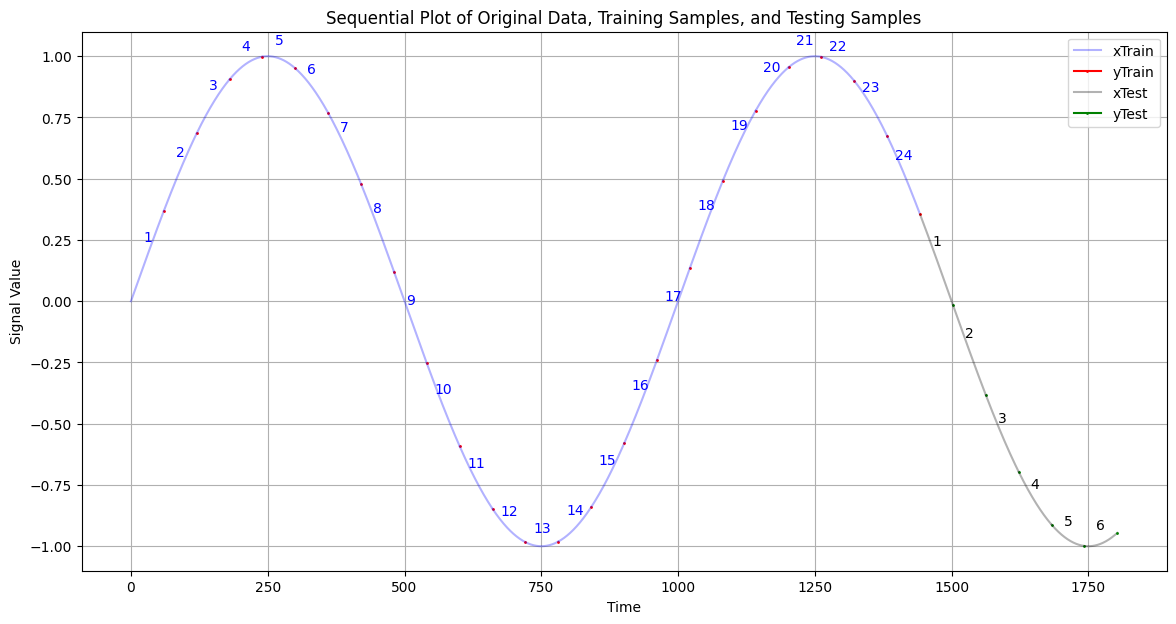

In [32]:

def plot_sequential_samples(univariate_data, x_train, y_train, x_test, y_test, delta_t):
    """
    Plots the original univariate data along with sequentially plotted x_train, y_train, x_test, and y_test.

    Parameters:
    - univariate_data: Original univariate time series data (1D array).
    - x_train: Training input data (2D array).
    - y_train: Training output data (2D array).
    - x_test: Testing input data (2D array).
    - y_test: Testing output data (2D array).
    - delta_t: The time interval between consecutive time steps.
    """
    plt.figure(figsize=(14, 7))

    # Plot original univariate data
    t_original = np.arange(len(univariate_data)) * delta_t
    # plt.plot(t_original, univariate_data, color='black', label='Original Data', linewidth=1.5)

    
    # Plot training data (x_train and y_train) sequentially
    lookback_period = x_train.shape[1]
    forecast_period = y_train.shape[1]
    start = 0
    for i in range(x_train.shape[0]):
        t_x_train = t_original[start:start + lookback_period]
        start += lookback_period
        t_y_train = t_original[start:start + forecast_period]
        start += forecast_period
        plt.plot(t_x_train, x_train[i], color='blue', alpha=0.3, linestyle='-', label='xTrain' if i == 0 else '')
        plt.annotate(f'{i+1}', (t_x_train[lookback_period//2], x_train[i, lookback_period//2]), textcoords="offset points", xytext=(0,10), ha='center', color='blue')
        plt.plot(t_y_train, y_train[i], color='red', marker = 'o', markersize = 1,label='yTrain' if i == 0 else '')
        # plt.annotate(f'{i+1}', (t_y_train[0], y_train[i, 0]), textcoords="offset points", xytext=(0,10), ha='center', color='red')


    # Plot testing data (x_test and y_test) sequentially
    for i in range(x_test.shape[0]):
        t_x_test = t_original[start:start + lookback_period]
        start += lookback_period
        t_y_test = t_original[start:start + forecast_period]
        start += forecast_period
        plt.plot(t_x_test, x_test[i], color='black', alpha=0.3, linestyle='-', label='xTest' if i == 0 else '')
        plt.annotate(f'{i+1}', (t_x_test[lookback_period//2], x_test[i, lookback_period//2]), textcoords="offset points", xytext=(0,10), ha='center', color='black')
        plt.plot(t_y_test, y_test[i], color='green', marker = 'o', markersize = 1, label='yTest' if i == 0 else '')

    plt.title("Sequential Plot of Original Data, Training Samples, and Testing Samples")
    plt.xlabel("Time")
    plt.ylabel("Signal Value")
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Example usage (assuming xTr, yTr, xTe, and yTe are defined)
plot_sequential_samples(univariate_data, xTr, yTr, xTe, yTe, delta_t)

# Models

**Training and Prediction Functions**

In [51]:
def train(model, xTrain, yTrain, xVal=None, yVal=None, epochs=10, batch_size=32, lr=0.001, shuffle=False):
    """
    General training function for PyTorch models.
    
    Parameters:
    - model (nn.Module): The PyTorch model to be trained.
    - xTrain (numpy.ndarray): Training data of shape (num_samples, timesteps, features).
    - yTrain (numpy.ndarray): Training labels of shape (num_samples, target_dim).
    - xVal (numpy.ndarray, optional): Validation data of shape (num_samples, timesteps, features).
    - yVal (numpy.ndarray, optional): Validation labels of shape (num_samples, target_dim).
    - epochs (int, optional): Number of epochs to train (default is 10).
    - batch_size (int, optional): Batch size (default is 32).
    - lr (float, optional): Learning rate for the optimizer (default is 0.001).
    - device (str, optional): Device to use for training ('cpu' or 'cuda'). If None, defaults to 'cpu'.
    
    Returns:
    - training_loss_history (list): History of training loss per epoch.
    - validation_loss_history (list): History of validation loss per epoch (if validation data is provided).
    """
    
    # Convert numpy arrays to PyTorch tensors and move them to the device
    xTrain = torch.from_numpy(xTrain).float()
    yTrain = torch.from_numpy(yTrain).float()
    
    if xVal is not None and yVal is not None:
        xVal = torch.from_numpy(xVal).float()
        yVal = torch.from_numpy(yVal).float()

    # Define loss function and optimizer
    criterion = nn.MSELoss()  # Can be changed based on the task (e.g., CrossEntropyLoss for classification)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # History to store loss per epoch
    training_loss_history = []
    validation_loss_history = []

    # Training loop
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        epoch_loss = 0.0
        
        if shuffle:
            # Shuffle the data at the beginning of each epoch
            permutation = torch.randperm(xTrain.size(0))
        else:
            # If no shuffling, maintain original order
            permutation = torch.arange(xTrain.size(0))

        # Process each batch
        for i in range(0, len(xTrain), batch_size):
            indices = permutation[i:i+batch_size]
            x_batch = xTrain[indices]
            y_batch = yTrain[indices]
            
            optimizer.zero_grad()  # Zero the gradients

            # Forward pass
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()

        # Average loss for the epoch
        training_loss_history.append(epoch_loss / len(xTrain))

        # Validation step (if provided)
        if xVal is not None and yVal is not None:
            model.eval()  # Set model to evaluation mode
            val_loss = 0.0
            with torch.no_grad():  # No need to track gradients during validation
                val_outputs = model(xVal)
                val_loss = criterion(val_outputs, yVal).item()

            validation_loss_history.append(val_loss)
            print(f'Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss/len(xTrain):.4f}, Validation Loss: {val_loss:.4f}')
        else:
            print(f'Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss/len(xTrain):.4f}')

    if xVal is not None and yVal is not None:
        return training_loss_history, validation_loss_history
    else:
        return training_loss_history


def predict(model, input_data):
    """
    Makes predictions using the provided PyTorch model and input data.
    
    Parameters:
    - model (nn.Module): The PyTorch model used for predictions.
    - input_data (numpy.ndarray): Input data of shape (batch_size, timesteps, features).
    
    Returns:
    - output (numpy.ndarray): Model predictions.
    """
    model.eval()  # Set the model to evaluation mode
    input_tensor = torch.from_numpy(input_data).float()  # Convert numpy to PyTorch tensor

    with torch.no_grad():  # No need to calculate gradients for predictions
        output_tensor = model(input_tensor)

    return output_tensor.numpy()  # Convert back to numpy array

def recursive_predict(model, input_data, nRecursive_predictions):
    """
    Perform recursive prediction with a PyTorch model by using the last predicted value as the next input.

    Parameters:
    - model (nn.Module): The PyTorch model used for predictions.
    - input_data (numpy.ndarray): Initial input data of shape (batch_size, timesteps, features).
    - nRecursive_predictions (int): Number of recursive predictions to make.
    
    Returns:
    - predictions (numpy.ndarray): Array of recursive predictions.
    """
    predictions = []
    current_input = torch.from_numpy(input_data).float()  # Convert to tensor

    model.eval()
    
    for _ in range(nRecursive_predictions):
        with torch.no_grad():
            # Predict the next timestep
            next_pred = model(current_input)
            predictions.append(next_pred.numpy())  # Store prediction

        # Shift the input sequence up by 1
        current_input = current_input.roll(shifts=-1, dims=1)
        # Replace the last timestep with the new prediction
        current_input[:, -1, :] = next_pred

    return np.array(predictions)

**Average Model**

In [34]:
'''
This model requires no training
Predicts the next point as an average of the training points
Works with multivarate data
Creates an mean vector for each sample
'''

def average_model_predict(series):
    return np.mean(series, axis = 1)

# multivariate_test_data = xTr #np.repeat(xTr,repeats=3,axis = -1)
# multivariate_test_data.shape

**Weighted Average Model:**
*Weights are learned during back propagation*

In [35]:

class WeightedAverageModel(nn.Module):
    def __init__(self, timesteps, features):
        """
        Weighted Average Model where the weights across timesteps are learned.

        Parameters:
        - timesteps (int): Number of timesteps in the input sequence.
        - features (int): Number of features in each timestep.
        """
        super(WeightedAverageModel, self).__init__()
        
        # Trainable weights for the timesteps
        self.weights = nn.Parameter(torch.randn(timesteps))  # Initialized randomly
    
    def forward(self, x):
        """
        Forward pass of the weighted average model.
        
        Parameters:
        - x (torch.Tensor): Input tensor of shape (num_samples, timesteps, features).
        
        Returns:
        - torch.Tensor: Weighted average tensor of shape (num_samples, 1, features).
        """
        # Apply softmax to ensure the weights sum to 1 and are positive
        softmax_weights = F.softmax(self.weights, dim=0)  # Shape (timesteps,)
        
        # Reshape weights to (1, timesteps, 1) to broadcast them across the batch and features
        weighted_input = x * softmax_weights.view(1, -1, 1)
        
        # Sum across the timesteps to get a weighted average
        weighted_average = torch.sum(weighted_input, dim=1, keepdim=True)  # Shape (num_samples, 1, features)
        
        return weighted_average
    
# # Example usage
# multivariate_test_data = xTr #np.repeat(xTr,repeats=3,axis = -1)
# multivariate_test_data.shape
# input_data = torch.from_numpy(multivariate_test_data).float()
# print(f"Input shape: {input_data.shape}")
# weighted_average_model = WeightedAverageModel(timesteps=input_data.shape[1], features=input_data.shape[2])
# output = weighted_average_model(input_data)
# print(f"Output shape: {output.shape}")

**LSTM Model**
*Single Value Prediction*

In [36]:
class LSTMUnivariateSinglePred(nn.Module):
    def __init__(self, timesteps, features, lstm_units=64):
        """
        LSTM Model for univariate time series with single-step prediction.

        Parameters:
        - timesteps (int): Number of timesteps in the input sequence.
        - features (int): Number of features at each timestep.
        - lstm_units (int): Number of units in the LSTM layer.
        """
        super(LSTMUnivariateSinglePred, self).__init__()
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size=features, hidden_size=lstm_units, batch_first=True)

        # Define the output Dense layer to map LSTM output to the correct number of features
        self.fc = nn.Linear(lstm_units, features)

    def forward(self, x):
        """
        Forward pass of the model.
        
        Parameters:
        - x (torch.Tensor): Input tensor of shape (batch_size, timesteps, features).
        
        Returns:
        - torch.Tensor: Predicted output for the next timestep, shape (batch_size, features).
        """
        # LSTM expects input of shape (batch_size, timesteps, features)
        lstm_out, _ = self.lstm(x)  # lstm_out shape: (batch_size, timesteps, lstm_units)
        
        # We only care about the output from the last timestep
        lstm_out = lstm_out[:, -1, :]  # shape: (batch_size, lstm_units)

        # Apply the dense layer to get the output of shape (batch_size, features)
        output = self.fc(lstm_out)  # shape: (batch_size, features)
        
        return output

# Testing Models

**Training weighted average + LSTM**

In [52]:
'''
Data is in xTr, yTr, xTe, yTe
'''
timesteps = xTr.shape[1]
features = xTr.shape[2]

weighted_average_model = WeightedAverageModel(timesteps=timesteps, features=features)
lstm_model = LSTMUnivariateSinglePred(timesteps=timesteps, features=features, lstm_units=64)

# Train the Weighted Average Model and capture the loss history
print("Training the Weighted Average Model...")
weighted_average_train_loss, weighted_average_val_loss = train(
    model=weighted_average_model,
    xTrain=xTr,
    yTrain=yTr,  
    xVal=xTe,  # Validation data
    yVal=yTe,  # Validation labels
    epochs=40,          
    batch_size=10,      
    lr=0.001,           
)

# Train the LSTM Model and capture the loss history
print("Training the LSTM Model...")
lstm_train_loss, lstm_val_loss = train(
    model=lstm_model,
    xTrain=xTr,
    yTrain=yTr,  
    xVal=xTe,  # Validation data
    yVal=yTe,  # Validation labels
    epochs=40,          
    batch_size=10,      
    lr=0.001,           
)


Training the Weighted Average Model...
Epoch 1/20, Training Loss: 0.0021, Validation Loss: 0.0180
Epoch 2/20, Training Loss: 0.0021, Validation Loss: 0.0179
Epoch 3/20, Training Loss: 0.0021, Validation Loss: 0.0179
Epoch 4/20, Training Loss: 0.0021, Validation Loss: 0.0178
Epoch 5/20, Training Loss: 0.0021, Validation Loss: 0.0177
Epoch 6/20, Training Loss: 0.0021, Validation Loss: 0.0177
Epoch 7/20, Training Loss: 0.0021, Validation Loss: 0.0176
Epoch 8/20, Training Loss: 0.0020, Validation Loss: 0.0176
Epoch 9/20, Training Loss: 0.0020, Validation Loss: 0.0175
Epoch 10/20, Training Loss: 0.0020, Validation Loss: 0.0175
Epoch 11/20, Training Loss: 0.0020, Validation Loss: 0.0174
Epoch 12/20, Training Loss: 0.0020, Validation Loss: 0.0174
Epoch 13/20, Training Loss: 0.0020, Validation Loss: 0.0173
Epoch 14/20, Training Loss: 0.0020, Validation Loss: 0.0173
Epoch 15/20, Training Loss: 0.0020, Validation Loss: 0.0172
Epoch 16/20, Training Loss: 0.0020, Validation Loss: 0.0172
Epoch 17/2

/Users/arnav/Google Drive/Cornell/Coding Projects/emili_TimeSeriesPredictor/.venv/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10, 1, 1])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/arnav/Google Drive/Cornell/Coding Projects/emili_TimeSeriesPredictor/.venv/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/arnav/Google Drive/Cornell/Coding Projects/emili_TimeSeriesPredictor/.venv/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a

Epoch 1/20, Training Loss: 0.0596, Validation Loss: 0.7489
Epoch 2/20, Training Loss: 0.0578, Validation Loss: 0.7577
Epoch 3/20, Training Loss: 0.0563, Validation Loss: 0.7663
Epoch 4/20, Training Loss: 0.0548, Validation Loss: 0.7746
Epoch 5/20, Training Loss: 0.0535, Validation Loss: 0.7823
Epoch 6/20, Training Loss: 0.0523, Validation Loss: 0.7893
Epoch 7/20, Training Loss: 0.0512, Validation Loss: 0.7952
Epoch 8/20, Training Loss: 0.0501, Validation Loss: 0.7995
Epoch 9/20, Training Loss: 0.0493, Validation Loss: 0.8014
Epoch 10/20, Training Loss: 0.0487, Validation Loss: 0.7997
Epoch 11/20, Training Loss: 0.0484, Validation Loss: 0.7936
Epoch 12/20, Training Loss: 0.0483, Validation Loss: 0.7823
Epoch 13/20, Training Loss: 0.0483, Validation Loss: 0.7664
Epoch 14/20, Training Loss: 0.0483, Validation Loss: 0.7473
Epoch 15/20, Training Loss: 0.0482, Validation Loss: 0.7269
Epoch 16/20, Training Loss: 0.0480, Validation Loss: 0.7064
Epoch 17/20, Training Loss: 0.0478, Validation Lo

**Training and Validation Loss Curves**

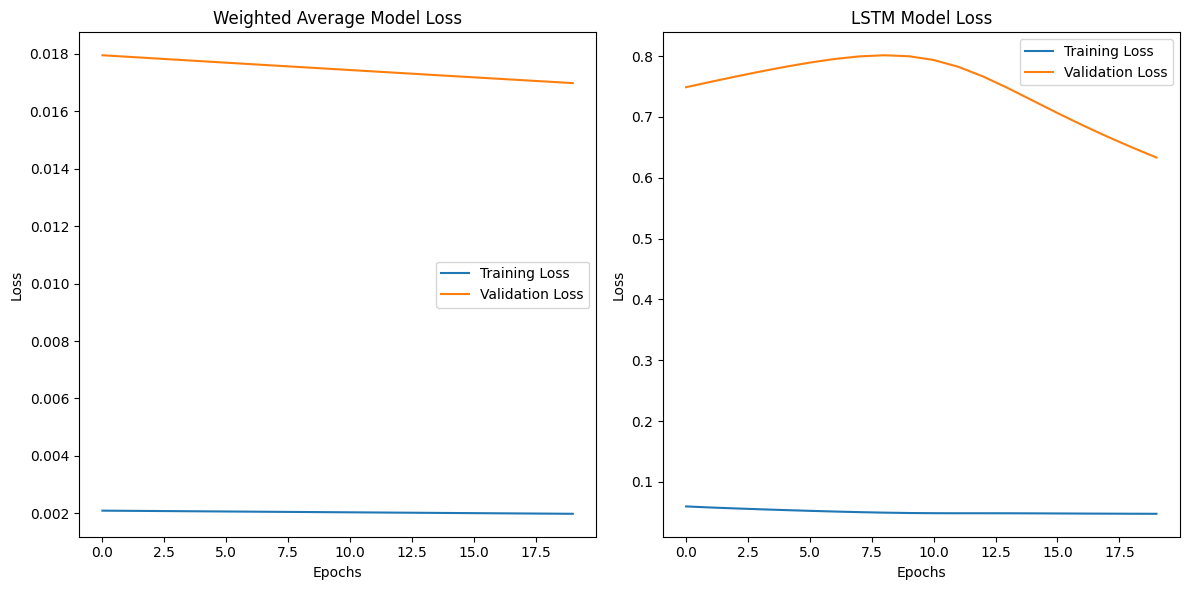

In [53]:
# Plot training and validation loss curves for the Weighted Average Model
plt.figure(figsize=(12, 6))

# Weighted Average Model loss curves
plt.subplot(1, 2, 1)
plt.plot(weighted_average_train_loss, label='Training Loss')
plt.plot(weighted_average_val_loss, label='Validation Loss')
plt.title("Weighted Average Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# LSTM Model loss curves
plt.subplot(1, 2, 2)
plt.plot(lstm_train_loss, label='Training Loss')
plt.plot(lstm_val_loss, label='Validation Loss')
plt.title("LSTM Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 37ms/step


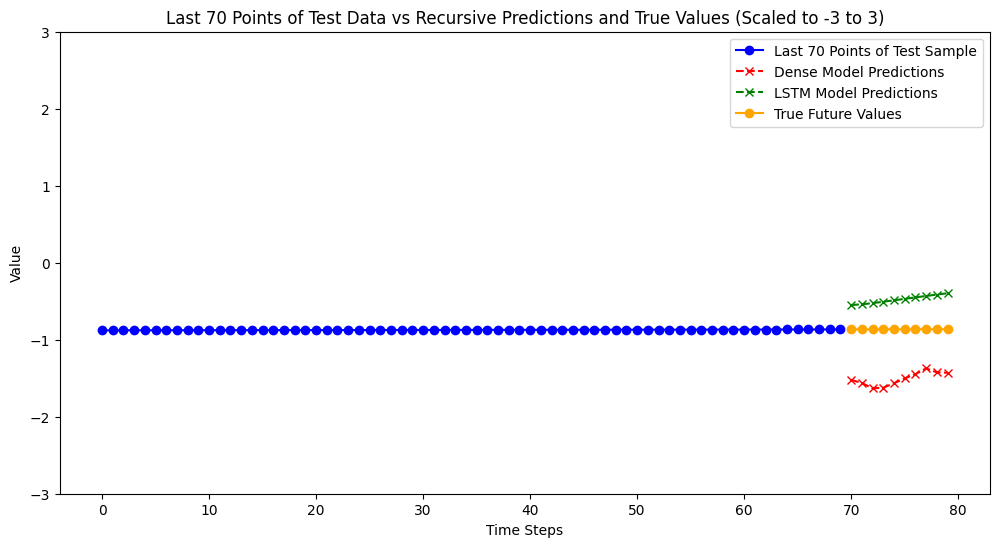

In [ ]:
# Select a sample from the test data
sample_index = 0
test_sample = xTe[sample_index:sample_index+1]  # Shape (1, timesteps, features)

# Extract the last 70 points of the test sample
num_points_to_show = 70
last_part_of_test_sample = test_sample[0, -num_points_to_show:, :].flatten()  # Last 70 points flattened

# Generate recursive predictions
num_steps = 10  # Number of steps to predict ahead
recursive_preds_dense = recursive_predict(weighted_avg_mdl, test_sample, num_steps)
recursive_preds_lstm = recursive_predict(lstm_model, test_sample, num_steps)

# Extract true future values from the next sample in xTe
true_values = xTe[sample_index + 1, :num_steps, :].flatten()  # True values from the next sample

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot the last part of the input sequence (test sample)
plt.plot(range(len(last_part_of_test_sample)), last_part_of_test_sample, color='blue', linestyle='-', marker='o', label='Last 70 Points of Test Sample')

# Plot the Dense model predictions right after the last input point
plt.plot(range(len(last_part_of_test_sample), len(last_part_of_test_sample) + num_steps), recursive_preds_dense.flatten(), color='red', linestyle='--', marker='x', label='Dense Model Predictions')

# Plot the LSTM model predictions right after the last input point
plt.plot(range(len(last_part_of_test_sample), len(last_part_of_test_sample) + num_steps), recursive_preds_lstm.flatten(), color='green', linestyle='--', marker='x', label='LSTM Model Predictions')

# Plot the true future values
plt.plot(range(len(last_part_of_test_sample), len(last_part_of_test_sample) + num_steps), true_values, color='orange', linestyle='-', marker='o', label='True Future Values')

# Scale the y-axis to the range of -3 to 3
plt.ylim(-3, 3)

plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Last 70 Points of Test Data vs Recursive Predictions and True Values (Scaled to -3 to 3)')
plt.legend()
plt.show()